# Risk Score System and Algorithm

In [ ]:
source("notebooks/initialize-data-analysis.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [ ]:
library(tidyverse)
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/

In [ ]:
data_refit <- model_full_BPM_1_A |>
  extract_mold() |>
  _$predictors |>
  mutate(across(where(is.numeric), ~ . / 10)) |>
  rename_with(~ paste0(., "_per_10"), .cols = where(is.numeric)) |>
  bind_cols(model_full_BPM_1_A |> extract_mold() |> _$outcomes)

model_refit <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = everything()) |>
  add_model(logistic_reg()) |>
  fit(data = data_refit)

model_refit_odds_ratios <- model_refit |>
  tidy(conf.int = TRUE, exponentiate = TRUE) |>
  select(term, estimate, conf.low, conf.high) |>
  filter(term != "(Intercept)") |>
  rename(odds_ratio = estimate, OR_lower = conf.low, OR_upper = conf.high) |>
  mutate(term = str_replace_all(term, "TRUE", ""))

# model_full_BPM_1_A |>
#   extract_mold() |>
#   _$predictors |> pull(baseline_PLT) |> quantile(c(0, 0.01, 0.99, 1), na.rm = TRUE)

## Risk Score System

All code below is not automatic. Variables and ranges are manually defined.

Current model predictors: `patient_age`, `baseline_CLCR`, `baseline_PLT`, `LZD_duration`, `comed_heparin`, `infect_sepsis`, `comorb_cirr`

In [ ]:
risk_profile_1 <- tibble(
  risk_factor = "patient_age",
  min_range = c(18, 30, 40, 50, 60, 70, 80, 90), # minimum age is 18
  max_range = lead(min_range, default = 101), # maximum age is 101, interval is 10
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_2 <- tibble(
  risk_factor = "baseline_CLCR",
  min_range = c(130, 90, 60, 30, 5), # 1% percentile is 5
  max_range = lag(min_range, default = 191), # 99% percentile is 191
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    min_range = replace(min_range, n(), -Inf),
    max_range = replace(max_range, 1, Inf),
    flag_base_risk = ifelse(min_range == 90, TRUE, flag_base_risk)
  )

risk_profile_3 <- tibble(
  risk_factor = "baseline_PLT",
  min_range = c(150, 75, 50, 25, 18), # 1% percentile is 18
  max_range = lag(min_range, default = 434), # 99% percentile is 434
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    min_range = replace(min_range, n(), -Inf),
    max_range = replace(max_range, 1, Inf),
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_4 <- tibble(
  risk_factor = "LZD_duration_14",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_5 <- tibble(
  risk_factor = "comed_heparin",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_6 <- tibble(
  risk_factor = "infect_sepsis",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_7 <- tibble(
  risk_factor = "comorb_cirr",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile <- bind_rows(risk_profile_1, risk_profile_2, risk_profile_3, risk_profile_4, risk_profile_5, risk_profile_6, risk_profile_7)

In [ ]:
B_constant <- parameter_estimates |>
  filter(risk_factor == "patient_age") |>
  pull(beta) * 10 # constant equivalent to 10-year increase in age

points_system_full <- parameter_estimates |>
  select(risk_factor, beta) |>
  right_join(risk_profile, by = "risk_factor") |>
  group_by(risk_factor) |>
  mutate(
    beta_sum = beta * (reference - reference[which.max(flag_base_risk)]),
    points = round(beta_sum / B_constant, 0)
  )

points_system_factors <- points_system_full |>
  select(risk_factor, min_range, max_range, points)

min_points <- points_system_full |>
  group_by(risk_factor) |>
  summarise(min_points = min(points)) |>
  summarise(total_min_points = sum(min_points)) |>
  pull(total_min_points)

max_points <- points_system_full |>
  group_by(risk_factor) |>
  summarise(max_points = max(points)) |>
  summarise(total_max_points = sum(max_points)) |>
  pull(total_max_points)

risk_function <- function(points) {
  intercept <- parameter_estimates |>
    filter(risk_factor == "Intercept") |>
    pull(beta)

  beta_base <- points_system_full |>
    filter(flag_base_risk == TRUE) |>
    ungroup() |>
    summarise(
      beta_base = sum(beta * reference)
    ) |>
    pull(beta_base)

  1 / (1 + exp(-(intercept + beta_base + B_constant * points)))
}

points_system_risks <- tibble(
  points_total = seq(min_points, max_points),
  risk_estimate = risk_function(points_total)
)


Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

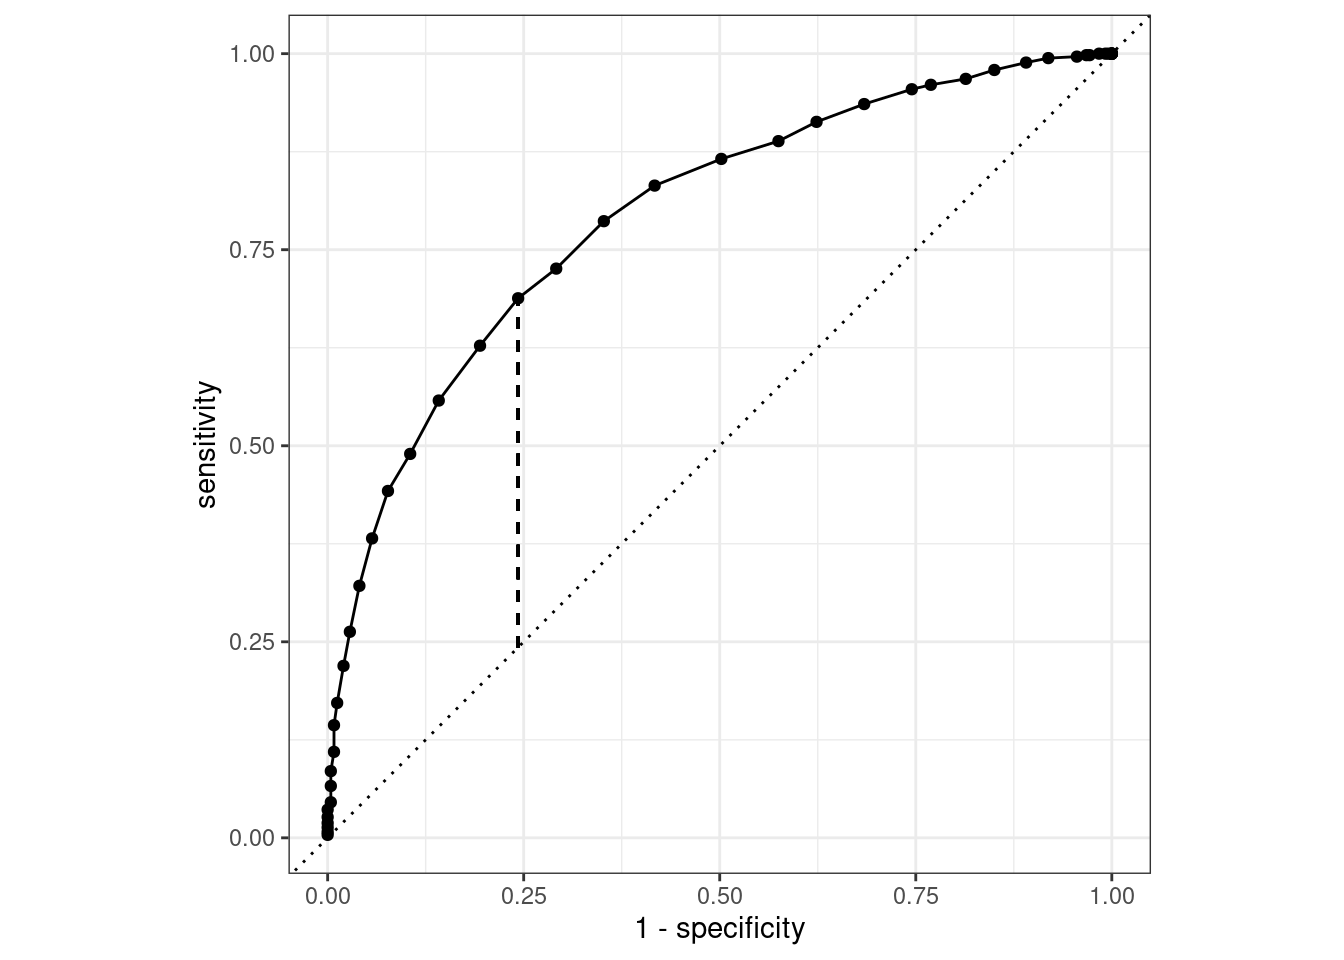

In [ ]:
library(probably)

In [ ]:
predictive_values |> knitr::kable()

  ------------------------------------------------------------------------------------
    .threshold   sensitivity   specificity         ppv         npv     j_index   score
  ------------ ------------- ------------- ----------- ----------- ----------- -------
     0.0271019     1.0000000     0.0000000   0.6817010         NaN   0.0000000      -2

     0.0322229     1.0000000     0.0000000   0.6817010         NaN   0.0000000      -1

     0.0382735     1.0000000     0.0000000   0.6817010         NaN   0.0000000       0

     0.0454069     1.0000000     0.0000000   0.6817010         NaN   0.0000000       1

     0.0537955     1.0000000     0.0000000   0.6817010         NaN   0.0000000       2

     0.0636306     1.0000000     0.0000000   0.6817010         NaN   0.0000000       3

     0.0751209     1.0000000     0.0040486   0.6825806   1.0000000   0.0040486       4

     0.0884901     1.0000000     0.0080972   0.6834625   1.0000000   0.0080972       5

     0.1039711     1.0000000     0.0161943   0.6852332   1.0000000   0.0161943       6

     0.1217985     0.9981096     0.0283401   0.6875000   0.8750000   0.0264497       7

     0.1421976     0.9981096     0.0323887   0.6883963   0.8888889   0.0304983       8

     0.1653698     0.9962193     0.0445344   0.6906946   0.8461538   0.0407537       9

     0.1914753     0.9943289     0.0809717   0.6985392   0.8695652   0.0753006      10

     0.2206125     0.9886578     0.1093117   0.7039031   0.8181818   0.0979696      11

     0.2527973     0.9792060     0.1497976   0.7115385   0.7708333   0.1290036      12

     0.2879428     0.9678639     0.1862348   0.7180926   0.7301587   0.1540987      13

     0.3258436     0.9603025     0.2307692   0.7277937   0.7307692   0.1910717      14

     0.3661678     0.9546314     0.2550607   0.7329463   0.7241379   0.2096921      15

     0.4084588     0.9357278     0.3157895   0.7454819   0.6964286   0.2515173      16

     0.4521498     0.9130435     0.3765182   0.7582418   0.6690647   0.2895617      17

     0.4965909     0.8884688     0.4251012   0.7679739   0.6402439   0.3135700      18

     0.5410860     0.8657845     0.4979757   0.7869416   0.6340206   0.3637602      19

     0.5849354     0.8317580     0.5829960   0.8103131   0.6180258   0.4147540      20

     0.6274796     0.7863894     0.6477733   0.8270378   0.5860806   0.4341627      21

     0.6681371     0.7258979     0.7085020   0.8421053   0.5468750   0.4343999      22

     0.7064332     0.6880907     0.7570850   0.8584906   0.5312500   0.4451758      23

     0.7420164     0.6275992     0.8056680   0.8736842   0.5025253   0.4332673      24

     0.7746623     0.5576560     0.8582996   0.8939394   0.4753363   0.4159555      25

     0.8042669     0.4896030     0.8947368   0.9087719   0.4501018   0.3843399      26

     0.8308314     0.4423440     0.9230769   0.9249012   0.4359465   0.3654210      27

     0.8544431     0.3818526     0.9433198   0.9351852   0.4160714   0.3251724      28

     0.8752541     0.3213611     0.9595142   0.9444444   0.3976510   0.2808752      29

     0.8934606     0.2627599     0.9716599   0.9520548   0.3809524   0.2344198      30

     0.9092853     0.2192817     0.9797571   0.9586777   0.3694656   0.1990387      31

     0.9229621     0.1720227     0.9878543   0.9680851   0.3577713   0.1598769      32

     0.9347250     0.1436673     0.9919028   0.9743590   0.3510029   0.1355701      33

     0.9447992     0.1096408     0.9919028   0.9666667   0.3421788   0.1015437      34

     0.9533961     0.0850662     0.9959514   0.9782609   0.3369863   0.0810176      35

     0.9607099     0.0661626     0.9959514   0.9722222   0.3324324   0.0621140      36

     0.9669157     0.0453686     0.9959514   0.9600000   0.3275632   0.0413200      37

     0.9721696     0.0359168     1.0000000   1.0000000   0.3262880   0.0359168      38

     0.9766095     0.0264650     1.0000000   1.0000000   0.3241470   0.0264650      39

     0.9803553     0.0189036     1.0000000   1.0000000   0.3224543   0.0189036      40

     0.9835114     0.0132325     1.0000000   1.0000000   0.3211964   0.0132325      41

     0.9861676     0.0075614     1.0000000   1.0000000   0.3199482   0.0075614      42

     0.9884009     0.0037807     1.0000000   1.0000000   0.3191214   0.0037807      43
  ------------------------------------------------------------------------------------


  risk_factor         min_range   max_range   points
  ----------------- ----------- ----------- --------
  LZD_duration_14             0           0        0
  LZD_duration_14             1           1        6
  comed_heparin               0           0        0
  comed_heparin               1           1        6
  infect_sepsis               0           0        0
  infect_sepsis               1           1        4
  baseline_CLCR             130         Inf       -2
  baseline_CLCR              90         130        0
  baseline_CLCR              60          90        1
  baseline_CLCR              30          60        2
  baseline_CLCR            -Inf          30        3
  patient_age                18          30        0
  patient_age                30          40        1
  patient_age                40          50        2
  patient_age                50          60        3
  patient_age                60          70        4
  patient_age                70          80        5
  patient_age                80          90        6
  patient_age                90         101        7
  baseline_PLT              150         Inf        0
  baseline_PLT               75         150        8
  baseline_PLT               50          75       11
  baseline_PLT               25          50       12
  baseline_PLT             -Inf          25       12
  comorb_cirr                 0           0        0
  comorb_cirr                 1           1        5


    points_total   risk_estimate
  -------------- ---------------
              -2       0.0271019
              -1       0.0322229
               0       0.0382735
               1       0.0454069
               2       0.0537955
               3       0.0636306
               4       0.0751209
               5       0.0884901
               6       0.1039711
               7       0.1217985
               8       0.1421976
               9       0.1653698
              10       0.1914753
              11       0.2206125
              12       0.2527973
              13       0.2879428
              14       0.3258436
              15       0.3661678
              16       0.4084588
              17       0.4521498
              18       0.4965909
              19       0.5410860
              20       0.5849354
              21       0.6274796
              22       0.6681371
              23       0.7064332
              24       0.7420164
              25       0.7746623
              26       0.8042669
              27       0.8308314
              28       0.8544431
              29       0.8752541
              30       0.8934606
              31       0.9092853
              32       0.9229621
              33       0.9347250
              34       0.9447992
              35       0.9533961
              36       0.9607099
              37       0.9669157
              38       0.9721696
              39       0.9766095
              40       0.9803553
              41       0.9835114
              42       0.9861676
              43       0.9884009


# BMA Black Box (13 variables)

In [ ]:
library(BAS)
model_black_box_estimates <- coef(model_black_box) |>
  confint(nsim = 2^20) |>
  structure(class = c("confint.bas", "matrix")) |>
  as_tibble() |>
  mutate(
    term = model_black_box$namesx |>
      str_extract(paste(c(variables_to_screen_short, "Intercept"), collapse = "|")) |>
      unique()
  ) |>
  relocate(c(term, beta)) |>
  rename(
    risk_factor = term,
    lower = `2.5%`,
    upper = `97.5%`
  ) |>
  mutate(across(c(lower, upper, beta), as.double))

model_black_box_odds_ratio <- model_black_box_estimates |>
  mutate(across(c(lower, upper, beta), exp)) |>
  rename(
    odds_ratio = beta
  )

In [ ]:
risk_profile_BMA_1 <- tibble(
  risk_factor = "patient_age",
  min_range = c(18, 30, 40, 50, 60, 70, 80, 90), # minimum age is 18
  max_range = lead(min_range, default = 101), # maximum age is 101, interval is 10
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_2 <- tibble(
  risk_factor = "baseline_CLCR",
  min_range = c(130, 90, 60, 30, 5), # 1% percentile is 5
  max_range = lag(min_range, default = 191), # 99% percentile is 191
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    min_range = replace(min_range, n(), -Inf),
    max_range = replace(max_range, 1, Inf),
    flag_base_risk = ifelse(min_range == 90, TRUE, flag_base_risk)
  )

risk_profile_BMA_3 <- tibble(
  risk_factor = "baseline_PLT",
  min_range = c(150, 75, 50, 25, 18), # 1% percentile is 18
  max_range = lag(min_range, default = 434), # 99% percentile is 434
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    min_range = replace(min_range, n(), -Inf),
    max_range = replace(max_range, 1, Inf),
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_4 <- tibble(
  risk_factor = "LZD_duration_14",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_5 <- tibble(
  risk_factor = "comed_heparin",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_6 <- tibble(
  risk_factor = "infect_sepsis",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_7 <- tibble(
  risk_factor = "dept_ICU",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_8 <- tibble(
  risk_factor = "comorb_cirr",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_9 <- tibble(
  risk_factor = "invasive_CRRT",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_10 <- tibble(
  risk_factor = "comed_enoxaparin",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_11 <- tibble(
  risk_factor = "LZD_route_IV",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_12 <- tibble(
  risk_factor = "infect_septicemia",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_13 <- tibble(
  risk_factor = "invasive_IHD",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA <- paste0("risk_profile_BMA_", 1:13) |> mget() |> bind_rows()

In [ ]:
B_constant <- model_black_box_estimates |>
  filter(risk_factor == "patient_age") |>
  pull(beta) * 10 # constant equivalent to 10-year increase in age

points_system_full_BMA <- model_black_box_estimates |>
  select(risk_factor, beta) |>
  right_join(risk_profile_BMA, by = "risk_factor") |>
  group_by(risk_factor) |>
  mutate(
    beta_sum = beta * (reference - reference[which.max(flag_base_risk)]),
    points = round(beta_sum / B_constant, 0)
  )

points_system_factors_BMA <- points_system_full_BMA |>
  select(risk_factor, min_range, max_range, points) |>
  group_by(risk_factor) |>
  mutate(flag_significant = any(points != 0)) |>
  filter(flag_significant) |>
  select(-flag_significant) |>
  ungroup()

min_points <- points_system_full_BMA |>
  group_by(risk_factor) |>
  summarise(min_points = min(points)) |>
  summarise(total_min_points = sum(min_points)) |>
  pull(total_min_points)

max_points <- points_system_full_BMA |>
  group_by(risk_factor) |>
  summarise(max_points = max(points)) |>
  summarise(total_max_points = sum(max_points)) |>
  pull(total_max_points)

risk_function_BMA <- function(points) {
  intercept <- model_black_box_estimates |>
    filter(risk_factor == "Intercept") |>
    pull(beta)

  beta_base <- points_system_full_BMA |>
    filter(flag_base_risk == TRUE) |>
    ungroup() |>
    summarise(
      beta_base = sum(beta * reference)
    ) |>
    pull(beta_base)

  1 / (1 + exp(-(intercept + beta_base + B_constant * points)))
}

points_system_risks_BMA <- tibble(
  points_total = seq(min_points, max_points),
  risk_estimate = risk_function_BMA(points_total)
)

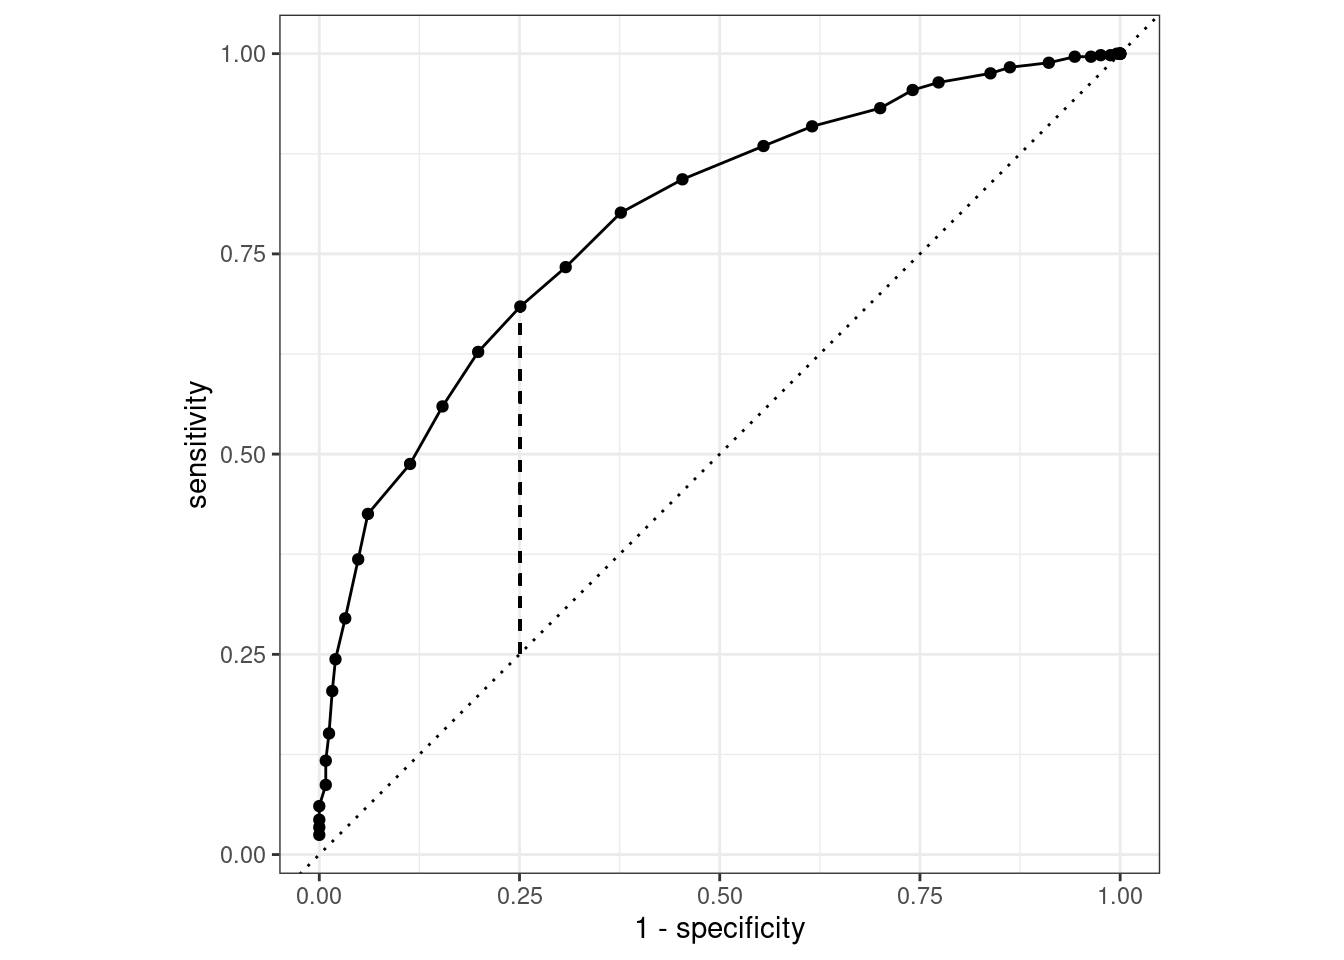

In [ ]:
library(probably)

BMA_pred <- predict(model_black_box, type = "response")

predictive_values_BMA <- BMA_pred$fit |>
  as_tibble() |>
  rename(.pred_TRUE = value) |>
  mutate(
    .pred_FALSE = 1 - .pred_TRUE,
    flag_ADR_TP_ID = data_patient_transformed$flag_ADR_TP_ID |> as_factor()
  ) |>
  threshold_perf(
    truth = flag_ADR_TP_ID,
    estimate = .pred_FALSE,
    thresholds = points_system_risks_BMA |> pull(risk_estimate),
    metrics = metric_set(sensitivity, specificity, ppv, npv, j_index)
  ) |>
  select(-.estimator) |>
  pivot_wider(names_from = .metric, values_from = .estimate) |>
  mutate(score = points_system_risks_BMA |> pull(points_total))

predictive_values_BMA |>
  select(.threshold, sensitivity, specificity) |>
  ggplot(aes(x = 1 - specificity, y = sensitivity)) +
  geom_point() +
  geom_path() +
  geom_segment(
    x = 1 - (predictive_values_BMA |> filter(j_index == max(j_index)) |> pull(specificity)),
    xend = 1 - (predictive_values_BMA |> filter(j_index == max(j_index)) |> pull(specificity)),
    y = 1 - (predictive_values_BMA |> filter(j_index == max(j_index)) |> pull(specificity)),
    yend = predictive_values_BMA |> filter(j_index == max(j_index)) |> pull(sensitivity),
    linetype = 2
  ) +
  geom_abline(lty = 3) +
  coord_equal() +
  theme_bw()

In [ ]:
predictive_values_BMA |> knitr::kable()

  ------------------------------------------------------------------------------------
    .threshold   sensitivity   specificity         ppv         npv     j_index   score
  ------------ ------------- ------------- ----------- ----------- ----------- -------
     0.0337956     1.0000000     0.0000000   0.6817010         NaN   0.0000000      -1

     0.0405833     1.0000000     0.0000000   0.6817010         NaN   0.0000000       0

     0.0486657     1.0000000     0.0000000   0.6817010         NaN   0.0000000       1

     0.0582599     1.0000000     0.0000000   0.6817010         NaN   0.0000000       2

     0.0696072     1.0000000     0.0000000   0.6817010         NaN   0.0000000       3

     0.0829698     1.0000000     0.0000000   0.6817010         NaN   0.0000000       4

     0.0986258     1.0000000     0.0040486   0.6825806   1.0000000   0.0040486       5

     0.1168596     0.9981096     0.0121457   0.6839378   0.7500000   0.0102554       6

     0.1379484     0.9981096     0.0242915   0.6866060   0.8571429   0.0224011       7

     0.1621443     0.9962193     0.0364372   0.6888889   0.8181818   0.0326565       8

     0.1896505     0.9962193     0.0566802   0.6934211   0.8750000   0.0528994       9

     0.2205942     0.9886578     0.0890688   0.6991979   0.7857143   0.0777267      10

     0.2549981     0.9829868     0.1376518   0.7094134   0.7906977   0.1206386      11

     0.2927522     0.9754253     0.1619433   0.7136929   0.7547170   0.1373687      12

     0.3335931     0.9640832     0.2267206   0.7275321   0.7466667   0.1908038      13

     0.3770937     0.9546314     0.2591093   0.7340116   0.7272727   0.2137407      14

     0.4226690     0.9319471     0.2995951   0.7402402   0.6727273   0.2315422      15

     0.4695999     0.9092628     0.3846154   0.7598736   0.6643357   0.2938781      16

     0.5170748     0.8846881     0.4453441   0.7735537   0.6432749   0.3300322      17

     0.5642434     0.8431002     0.5465587   0.7992832   0.6192661   0.3896589      18

     0.6102773     0.8015123     0.6234818   0.8201161   0.5945946   0.4249941      19

     0.6544265     0.7334594     0.6923077   0.8362069   0.5480769   0.4257670      20

     0.6960652     0.6843100     0.7489879   0.8537736   0.5255682   0.4332979      21

     0.7347205     0.6275992     0.8016194   0.8713911   0.5012658   0.4292187      22

     0.7700834     0.5595463     0.8461538   0.8862275   0.4728507   0.4057002      23

     0.8020026     0.4877127     0.8866397   0.9020979   0.4469388   0.3743523      24

     0.8304661     0.4253308     0.9392713   0.9375000   0.4328358   0.3646021      25

     0.8555746     0.3686200     0.9514170   0.9420290   0.4130053   0.3200370      26

     0.8775130     0.2948960     0.9676113   0.9512195   0.3905229   0.2625074      27

     0.8965219     0.2438563     0.9797571   0.9626866   0.3769470   0.2236134      28

     0.9128737     0.2041588     0.9838057   0.9642857   0.3659639   0.1879645      29

     0.9268524     0.1512287     0.9878543   0.9638554   0.3520924   0.1390830      30

     0.9387388     0.1172023     0.9919028   0.9687500   0.3441011   0.1091051      31

     0.9488004     0.0869565     0.9919028   0.9583333   0.3365385   0.0788594      32

     0.9572847     0.0604915     1.0000000   1.0000000   0.3319892   0.0604915      33

     0.9644157     0.0434783     1.0000000   1.0000000   0.3280212   0.0434783      34

     0.9703931     0.0340265     1.0000000   1.0000000   0.3258575   0.0340265      35

     0.9753921     0.0245747     1.0000000   1.0000000   0.3237221   0.0245747      36
  ------------------------------------------------------------------------------------


  risk_factor         min_range   max_range   points
  ----------------- ----------- ----------- --------
  LZD_duration_14             0           0        0
  LZD_duration_14             1           1        5
  comed_heparin               0           0        0
  comed_heparin               1           1        5
  infect_sepsis               0           0        0
  infect_sepsis               1           1        3
  baseline_CLCR             130         Inf       -1
  baseline_CLCR              90         130        0
  baseline_CLCR              60          90        1
  baseline_CLCR              30          60        1
  baseline_CLCR            -Inf          30        1
  patient_age                18          30        0
  patient_age                30          40        1
  patient_age                40          50        2
  patient_age                50          60        3
  patient_age                60          70        4
  patient_age                70          80        5
  patient_age                80          90        6
  patient_age                90         101        7
  baseline_PLT              150         Inf        0
  baseline_PLT               75         150        8
  baseline_PLT               50          75       10
  baseline_PLT               25          50       11
  baseline_PLT             -Inf          25       12
  comorb_cirr                 0           0        0
  comorb_cirr                 1           1        2
  invasive_CRRT               0           0        0
  invasive_CRRT               1           1        1


    points_total   risk_estimate
  -------------- ---------------
              -1       0.0337956
               0       0.0405833
               1       0.0486657
               2       0.0582599
               3       0.0696072
               4       0.0829698
               5       0.0986258
               6       0.1168596
               7       0.1379484
               8       0.1621443
               9       0.1896505
              10       0.2205942
              11       0.2549981
              12       0.2927522
              13       0.3335931
              14       0.3770937
              15       0.4226690
              16       0.4695999
              17       0.5170748
              18       0.5642434
              19       0.6102773
              20       0.6544265
              21       0.6960652
              22       0.7347205
              23       0.7700834
              24       0.8020026
              25       0.8304661
              26       0.8555746
              27       0.8775130
              28       0.8965219
              29       0.9128737
              30       0.9268524
              31       0.9387388
              32       0.9488004
              33       0.9572847
              34       0.9644157
              35       0.9703931
              36       0.9753921
